## Regression Model for predicting car fuel efficiency

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

### Dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = df[cols]
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


### EDA

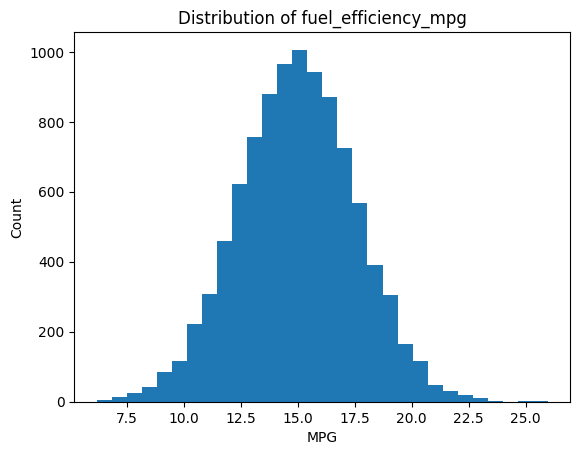

In [5]:
plt.hist(df['fuel_efficiency_mpg'], bins=30)
plt.title('Distribution of fuel_efficiency_mpg')
plt.xlabel('MPG')
plt.ylabel('Count')
plt.show()  

The fuel_efficiency_mpg does not have a long tail — it’s approximately normally distributed.

### Question 1
There's one column with missing values. What is it?

In [6]:
missing = df.isna().sum()
q1_answer = missing[missing > 0].index[0]
print("Q1: Column with missing values is:", q1_answer)

Q1: Column with missing values is: horsepower


### Question 2
What's the median (50% percentile) for variable 'horsepower'?

In [7]:
h_median = df['horsepower'].median()
print("Q2: Median horsepower is:", h_median)

Q2: Median horsepower is: 149.0


In [8]:
def split_dataset(df, seed=42):
    np.random.seed(seed)
    df_shuffled = df.sample(frac=1, random_state=seed)
    n = len(df_shuffled)
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    df_train = df_shuffled.iloc[:n_train]
    df_val = df_shuffled.iloc[n_train:n_train + n_val]
    df_test = df_shuffled.iloc[n_train + n_val:]
    return df_train, df_val, df_test

df_train, df_val, df_test = split_dataset(df, seed=42)  

In [9]:
def get_X_y(df):
    X = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']].values
    y = df['fuel_efficiency_mpg'].values
    return X, y

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

### Question 3

In [10]:
def fill_and_evaluate(method='zero'):
    train = df_train.copy()
    val = df_val.copy()

    # dealing with missing values and filling them with zero
    if method == 'zero':
        train = train.fillna(0)
        val = val.fillna(0)
    elif method == 'mean':
        mean_values = train.mean(numeric_only=True)
        train = train.fillna(mean_values)
        val = val.fillna(mean_values)
    else:
        raise ValueError("method must be 'zero' or 'mean'")

    # Next we Extract features and target
    X_train, y_train = get_X_y(train)
    X_val, y_val = get_X_y(val)

    # Training the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # RMSE 
    rmse_value = np.sqrt(mean_squared_error(y_val, y_pred))

    return round(rmse_value, 2)

# Evaluating both methods
rmse_zero = fill_and_evaluate('zero')
rmse_mean = fill_and_evaluate('mean')

# Choosing the better option
if rmse_zero < rmse_mean:
    q3_answer = 'With 0'
elif rmse_mean < rmse_zero:
    q3_answer = 'With mean'
else:
    q3_answer = 'Both are equally good'

print("Q3 -> Fill 0 RMSE:", rmse_zero)
print("Q3 -> Fill mean RMSE:", rmse_mean)
print("Q3 Answer:", q3_answer)


Q3 -> Fill 0 RMSE: 0.52
Q3 -> Fill mean RMSE: 0.46
Q3 Answer: With mean


### Question 4
Training a regularized linear regression (Ridge regularization)

In [11]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_scores = {}

# Filling missing values with 0
train_filled = df_train.fillna(0)
val_filled = df_val.fillna(0)

# Preparing X, y for training and validation
X_train, y_train = get_X_y(train_filled)
X_val, y_val = get_X_y(val_filled)

# Looping through each r value
for r in r_values:
    if r == 0:
        model = LinearRegression()
    else:
        model = Ridge(alpha=r)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Computing RMSE 
    rmse_value = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores[r] = round(rmse_value, 2)

print("Validation RMSE per r:")
for r, score in rmse_scores.items():
    print(f"r={r}: RMSE={score}")

# Pick best r (lowest RMSE, smallest r if tied)
best_r = min(rmse_scores, key=lambda k: (rmse_scores[k], k))
q4_answer = best_r

print("\nQ4 Answer -> Best r:", q4_answer)


Validation RMSE per r:
r=0: RMSE=0.52
r=0.01: RMSE=0.52
r=0.1: RMSE=0.52
r=1: RMSE=0.52
r=5: RMSE=0.52
r=10: RMSE=0.52
r=100: RMSE=0.52

Q4 Answer -> Best r: 0


### Question 5 
Effect of Seed on Validation RMSE

In [12]:
val_scores = []

for seed in range(10):
    # Split dataset with current seed
    df_train, df_val, df_test = split_dataset(df, seed=seed)

    # Fill missing values with 0
    train_filled = df_train.fillna(0)
    val_filled = df_val.fillna(0)

    # features and target
    X_train, y_train = get_X_y(train_filled)
    X_val, y_val = get_X_y(val_filled)

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and compute RMSE
    y_pred = model.predict(X_val)
    rmse_value = np.sqrt(mean_squared_error(y_val, y_pred))
    val_scores.append(round(rmse_value, 2))

# standard deviation of RMSEs
std_rmse = round(np.std(val_scores), 3)
q5_answer = std_rmse

print("Validation RMSEs for seeds 0–9:", val_scores)
print("\nQ5 Answer -> Std of RMSEs:", q5_answer)


Validation RMSEs for seeds 0–9: [np.float64(0.52), np.float64(0.52), np.float64(0.52), np.float64(0.52), np.float64(0.51), np.float64(0.53), np.float64(0.53), np.float64(0.51), np.float64(0.51), np.float64(0.51)]

Q5 Answer -> Std of RMSEs: 0.007


 ### Question 6 

In [13]:
# Split data, seed=9
df_train, df_val, df_test = split_dataset(df, seed=9)

# Combine train + validation
df_train_val = pd.concat([df_train, df_val]).reset_index(drop=True)

# Fill missing values with 0
train_val_filled = df_train_val.fillna(0)
test_filled = df_test.fillna(0)

# features and targets
X_train_val, y_train_val = get_X_y(train_val_filled)
X_test, y_test = get_X_y(test_filled)

# Train Ridge model (r = 0.001)
model = Ridge(alpha=0.001)
model.fit(X_train_val, y_train_val)

# Predict and compute RMSE
y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
q6_answer = round(rmse_test, 3)

print("Q6 -> Test RMSE (r = 0.001, seed = 9):", q6_answer)


Q6 -> Test RMSE (r = 0.001, seed = 9): 0.515
